# Метрические методы классификации и регрессии

## Библиотеки

In [8]:
!pip install scikit-learn


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: C:\Users\Грязев Артём\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [12]:
!pip install seaborn

                                              0.0/293.3 kB ? eta -:--:--
                                              0.0/293.3 kB ? eta -:--:--
     -                                        10.2/293.3 kB ? eta -:--:--
     -                                        10.2/293.3 kB ? eta -:--:--
     -                                        10.2/293.3 kB ? eta -:--:--
     ---                                   30.7/293.3 kB 163.8 kB/s eta 0:00:02
     -----                                 41.0/293.3 kB 163.4 kB/s eta 0:00:02
     -----                                 41.0/293.3 kB 163.4 kB/s eta 0:00:02
     -------                               61.4/293.3 kB 181.6 kB/s eta 0:00:02
     -------                               61.4/293.3 kB 181.6 kB/s eta 0:00:02
     ---------                             71.7/293.3 kB 170.7 kB/s eta 0:00:02
     -----------                           92.2/293.3 kB 187.0 kB/s eta 0:00:02
     -----------                           92.2/293.3 kB 187.0 kB/s eta 


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: C:\Users\Грязев Артём\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import warnings
warnings.filterwarnings("ignore")
!wget -q -O requirements.txt https://raw.githubusercontent.com/andriygav/MachineLearningSeminars/master/sem4/requirements.txt
!pip install -q -U -r requirements.txt

"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [943 lines of output]
      Ignoring numpy: markers 'python_version == "3.6" and platform_system != "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.7" and platform_system != "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.6" and platform_system == "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.7" and platform_system == "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version >= "3.8" and platform_system == "AIX"' don't match your environment
        Using cached setuptools-68.1.2-py3-none-any.whl (805 kB)
        Using cached wheel-0.41.2-py3-none-any.whl (64 kB)
                                                    0.0/2.8 MB ? eta

In [13]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

from scipy.special import softmax
from scipy.spatial.distance import cdist
import numpy as np
import torch

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_decision_regions

## Разбор домашнего задания

### Минусы эксперимента по подбору гиперпараметров
* Количество эпох является фиксируемой величиной, не был проведен подбор количества эпох.
* Слишком мало параметров для подбора. На семинаре был выполнен такой маленький подбор, только чтобы все выполнилось быстро, в реальных задачах требуется делать более подробную сетку.
* Для более качественного анализа нужно смотреть не только на среднее, а еще и на дисперсию ошибки. Но это недостаток самого метода скользящего контроля.

## Почему метрические классификаторы

Основное свойство метрического классификатора в том, что в данном случае не нужны признаки, а важна только функция расстояния.

Почему мы можем отказаться от признакового описания объектов?

На лекции по SVM будет получено следующее выражение для линейного классификатора:
$$
\hat{\mathbf{w}} = \sum_{i=1}^{l}\lambda_i\mathbf{x}_i,
$$
где $\mathbf{x}_i$ признаковое описание i-го объекта. Теперь, чтобы получить предсказания модели получаем:
$$
y = \text{sign}\bigr(\hat{\mathbf{w}}^{\mathsf{T}}\mathbf{x}\bigr) = \text{sign}\bigr(\sum_{i=1}^{l}\lambda_i  \color{red}{\mathbf{x}_i^{\mathsf{T}}\mathbf{x}}\bigr).
$$

Заметим, что скалярное произведение это не является метрикой, но идея того, что предсказания не зависит от признаков объектов, а только от некоторой числовой характеристики.

## Датасет

In [23]:
X, Y = make_classification(n_samples=150, n_features=2, 
                           n_informative=2, n_classes=2, 
                           n_redundant=0,
                           n_clusters_per_class=2,
                           random_state=0)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=50, 
                                                    random_state=0)

## Метод ближайшего соседа

In [24]:
model = KNeighborsClassifier(n_neighbors=1)
_ = model.fit(X_train, Y_train)

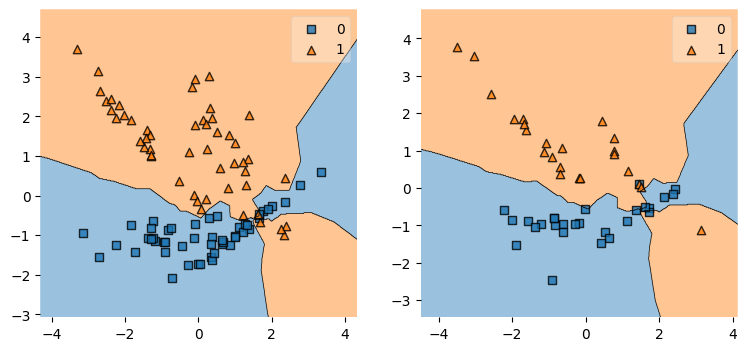

In [25]:
fig, gs = plt.figure(figsize=(9,4)), gridspec.GridSpec(1, 2)

ax = []
for i in range(2):
    ax.append(fig.add_subplot(gs[i]))

plot_decision_regions(X_train, Y_train, model, ax=ax[0])
plot_decision_regions(X_test, Y_test, model, ax=ax[1])

plt.show()

## Метод k-ближайших соседей

In [26]:
models = []
for n_neighbors in range(1, 50):
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, Y_train)
    models.append(model)

j =  4


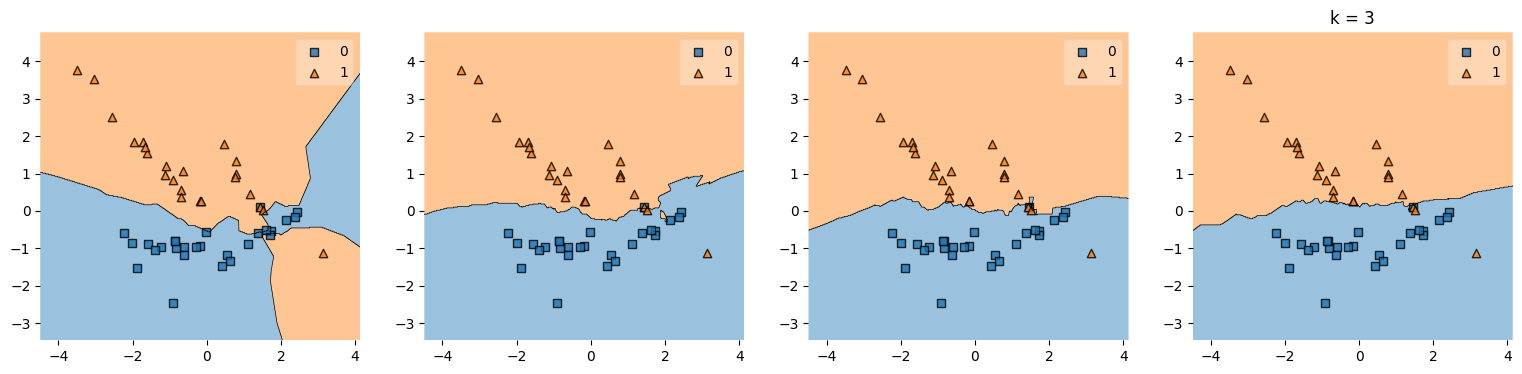

In [33]:
plots_num = 4
fig, gs = plt.figure(figsize=(19,plots_num)), gridspec.GridSpec(1, plots_num)

ax = []
for i in range(plots_num):
    ax.append(fig.add_subplot(gs[i]))

j = 0
for i in range(0, len(models), int(len(models)//plots_num)):
    model = models[i]
    tmp_ax = ax[j]
    plot_decision_regions(X_test, Y_test, models[i], ax=ax[j])
    plt.title("k = "+str(j))
    j += 1
    if j >= plots_num:
        #warn("j = "+str(j))
        print("j = ", j)
        break
plt.show()

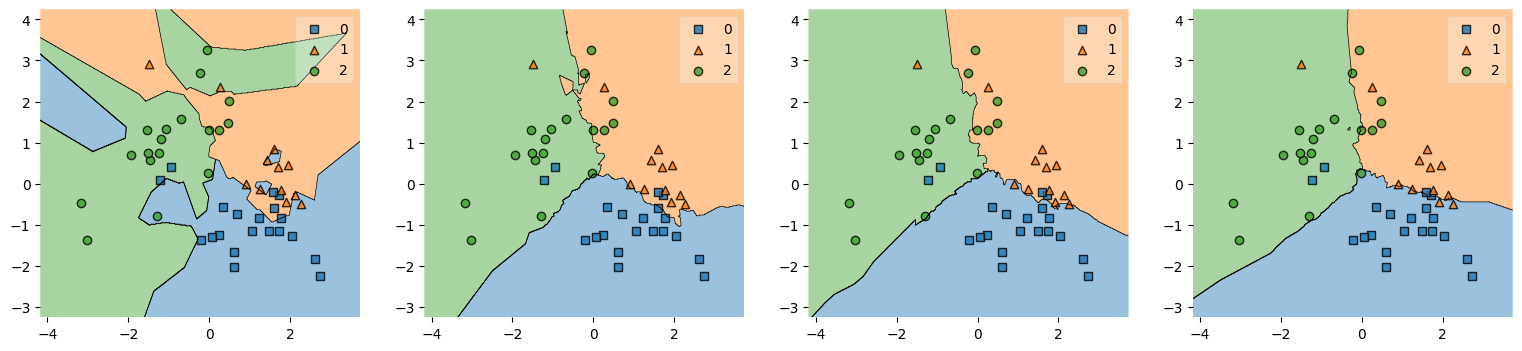

In [20]:
fig, gs = plt.figure(figsize=(19,4)), gridspec.GridSpec(1, 4)

ax = []
for i in range(4):
    ax.append(fig.add_subplot(gs[i]))

k_arr = [1, 3, 10, 40]
for i in range(4):
    plot_decision_regions(X_test, Y_test, models[12*i], ax=ax[i])

plt.show()

## Метод k-ближайших соседей с линейно убивающими весами

In [ ]:
def func(distance):
    ret = np.ones_like(distance)
    k = ret.shape[1]
    for i in range(k):
        ret[:, i] *= (k-i)/k
    return ret

In [ ]:
models = []
for n_neighbors in range(1, 51):
    model = KNeighborsClassifier(n_neighbors=n_neighbors, 
                                 weights=func)
    model.fit(X_train, Y_train)
    models.append(model)

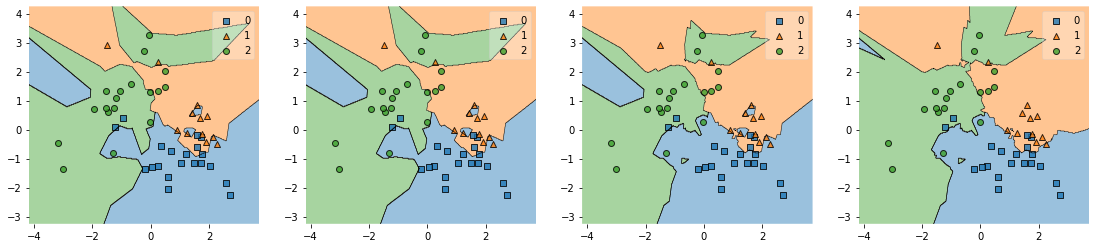

In [ ]:
fig, gs = plt.figure(figsize=(19,4)), gridspec.GridSpec(1, 4)

ax = []
for i in range(4):
    ax.append(fig.add_subplot(gs[i]))

for i in range(4):
    plot_decision_regions(X_test, Y_test, models[i], ax=ax[i])

plt.show()

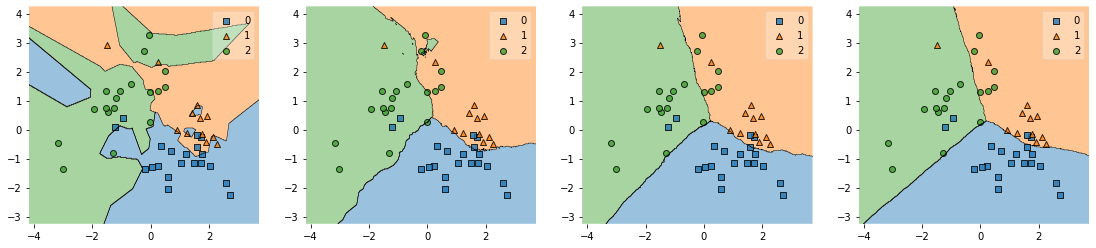

In [ ]:
fig, gs = plt.figure(figsize=(19,4)), gridspec.GridSpec(1, 4)

ax = []
for i in range(4):
    ax.append(fig.add_subplot(gs[i]))

for i in range(4):
    plot_decision_regions(X_test, Y_test, models[12*i], ax=ax[i])

plt.show()

## Метод окна Парзена

In [ ]:
def K(distance, h=0.05):
    ret = np.array(distance)/h
    return (1 - ret**2) * (np.abs(ret) <= 1)

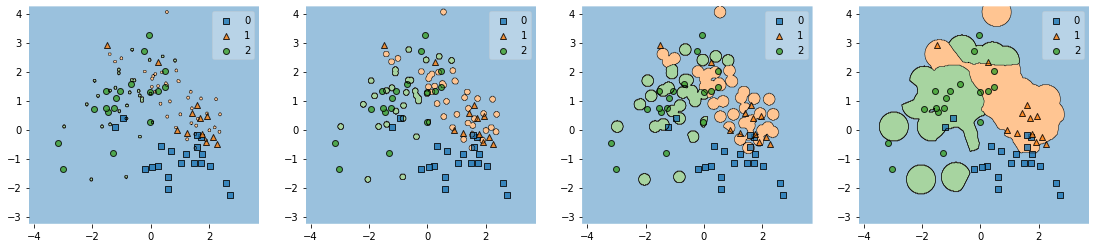

In [ ]:
fig, gs = plt.figure(figsize=(19,4)), gridspec.GridSpec(1, 4)

ax = []
for i, h in enumerate([0.05, 0.1, 0.2, 0.5]):
    model = KNeighborsClassifier(n_neighbors=len(X_train),
                                 weights=lambda x: K(x, h=h))
    model.fit(X_train, Y_train)
    ax.append(fig.add_subplot(gs[i]))
    plot_decision_regions(X_test, Y_test, model, ax=ax[i])

plt.show()

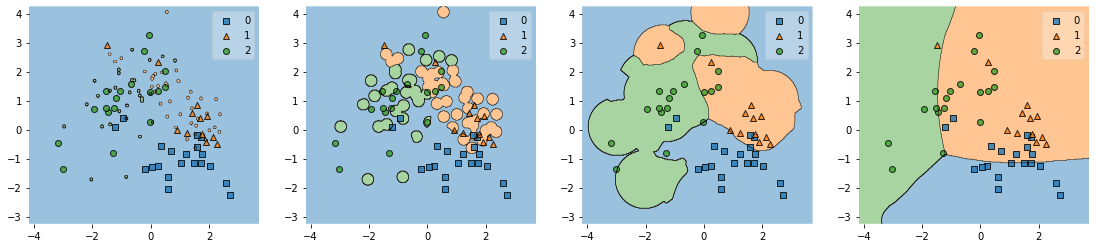

In [ ]:
fig, gs = plt.figure(figsize=(19,4)), gridspec.GridSpec(1, 4)

ax = []
for i, h in enumerate([0.05, 0.2, 1.0, 5.0]):
    model = KNeighborsClassifier(n_neighbors=len(X_train),
                                 weights=lambda x: K(x, h=h))
    model.fit(X_train, Y_train)
    ax.append(fig.add_subplot(gs[i]))
    plot_decision_regions(X_test, Y_test, model, ax=ax[i])

plt.show()

## Метод потенциальных функций

In [ ]:
X, Y = make_classification(n_samples=150, n_features=2, 
                           n_informative=2, n_classes=2, 
                           n_redundant=0,
                           n_clusters_per_class=1,
                           random_state=0)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=50, 
                                                    random_state=0)

### Реализации метода
Релазицию данного метода в стандартных пакетах не было найдено, поэтому выполнил простую реалзизацю.

In [ ]:
class PFM(object):
    def __init__(self, kernel=None):
        self.X, self.Y, self.gams = None, None, None
        self.kernel = lambda x: np.ones_like(x)
        if kernel is not None:
            self.kernel = kernel
    def scores(self, X):
        features = self.gams*self.kernel(cdist(X, self.X))
        scores = np.vstack(
            [np.sum(features.T[np.where(self.Y==0)[0]].T, axis=-1),
             np.sum(features.T[np.where(self.Y==1)[0]].T, axis=-1)]).T
        return scores
    def predict(self, X):
        return np.argmax(self.scores(X), axis=-1)
    def fit(self, X, Y, epoch=10):
        self.X, self.Y, self.gams = np.array(X), np.array(Y), np.zeros_like(Y)
        for _ in range(epoch):
            for i, (x, y) in enumerate(zip(self.X, self.Y)):
                if self.predict(np.array([x]))[0] != y:
                    self.gams[i] += 1

In [ ]:
def K(distance, h=0.05):
    ret = np.array(distance)/h
    return (1 - ret**2) * (np.abs(ret) <= 1)

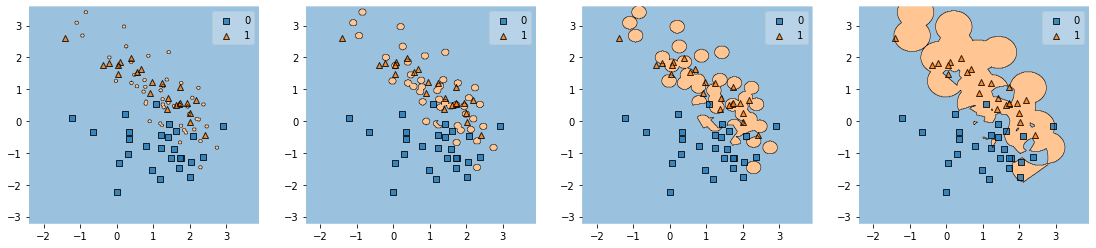

In [ ]:
fig, gs = plt.figure(figsize=(19,4)), gridspec.GridSpec(1, 4)

ax = []
for i, h in enumerate([0.05, 0.1, 0.2, 0.5]):
    model = PFM(kernel=lambda x: K(x, h=h))
    model.fit(X_train, Y_train)
    ax.append(fig.add_subplot(gs[i]))
    plot_decision_regions(X_test, Y_test, model, ax=ax[i])

plt.show()

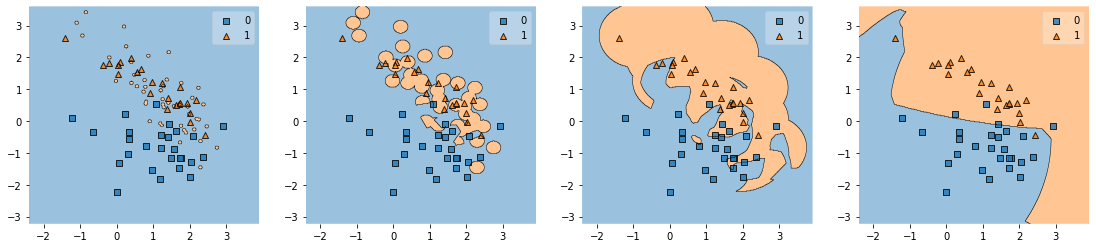

In [ ]:
fig, gs = plt.figure(figsize=(19,4)), gridspec.GridSpec(1, 4)

ax = []
for i, h in enumerate([0.05, 0.2, 1.0, 5.0]):
    model = PFM(kernel=lambda x: K(x, h=h))
    model.fit(X_train, Y_train)
    ax.append(fig.add_subplot(gs[i]))
    plot_decision_regions(X_test, Y_test, model, ax=ax[i])

plt.show()

## Отбор эталонных объектов

В данной части рассмотрим отбор эталонных объектов для метрических методов классификации.
Для начала введем понятия отступа для метрического классификатора:
$$
M\bigr(x_i\bigr) = \Gamma_{y_i}\bigr(x_i\bigr) - \max_{y\in Y\setminus{y_i}}\Gamma_{y}\bigr(x_i\bigr),
$$
другими словами, отступ показывает насколько истинный класс далеко от другого класса. В случае, если отступ положительный, то предсказание является верным. В случае, если отступ отрицательный, то предсказание является ошибочным.

In [ ]:
X, Y = make_classification(n_samples=350, n_features=2, 
                           n_informative=2, n_classes=2, 
                           n_redundant=0,
                           n_clusters_per_class=1,
                           random_state=0)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=150, 
                                                    random_state=0)

In [ ]:
def K(distance, h=0.2):
    ret = np.array(distance)/h
    return (1 - ret**2) * (np.abs(ret) <= 1)

In [ ]:
model = PFM(kernel=lambda x: K(x, h=2))
model.fit(X_train, Y_train)

M = [s[y] -s[y-1] for s, y in zip(model.scores(X_train), Y_train)]
M = np.array(sorted(M))

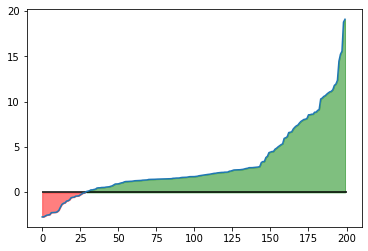

In [ ]:
x = list(range(len(M)))
plt.plot(x, M)

plt.hlines(0, 0, len(x), color='black')
plt.fill_between(x, M, where=M<0, color='red', alpha=0.5)
plt.fill_between(x, M, where=M>0, color='green', alpha=0.5)
plt.show()

### Алгоритм STOLP для отбора эталонных объектов

In [ ]:
def STOLP(X, Y, error=10, model=PFM(kernel=lambda x: K(x, h=2))):
    X, Y = np.array(X), np.array(Y)

    model.fit(X, Y)
    M = np.array(sorted([s[y] -s[y-1] for s, y in zip(model.scores(X), Y)]))

    Omega = []
    Omega.append(np.argmax(M*(Y==1) - 10000*(Y==0)))
    Omega.append(np.argmax(M*(Y==0) - 10000*(Y==1)))

    while len(Omega) != len(X):
        model.fit(X[Omega], Y[Omega])
        M = np.array(sorted([s[y] -s[y-1] for s, y in zip(model.scores(X), Y)]))
        M[Omega] = 10000
        if len(np.where(M <= 0)[0]) < error:
            break
        Omega.append(np.argmin(M))
    
    return Omega

In [ ]:
Omega = STOLP(X_train, Y_train)

In [ ]:
model = PFM(kernel=lambda x: K(x, h=2))
model.fit(X_train[Omega], Y_train[Omega])

M = [s[y] - s[y-1] for s, y in zip(model.scores(X_train), Y_train)]
M = np.array(sorted(M))

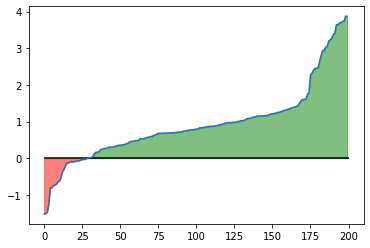

In [ ]:
x = list(range(len(M)))
plt.plot(x, M)

plt.hlines(0, 0, len(x), color='black')
plt.fill_between(x, M, where=M<0, color='red', alpha=0.5)
plt.fill_between(x, M, where=M>0, color='green', alpha=0.5)
plt.show()

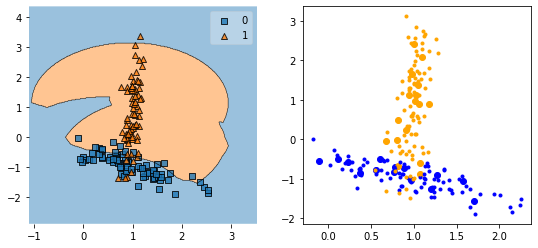

In [ ]:
fig, gs = plt.figure(figsize=(9,4)), gridspec.GridSpec(1, 2)
colors=['blue', 'orange']

ax = []
for i in range(2):
    ax.append(fig.add_subplot(gs[i]))
    
for k in np.unique(Y_train):
    ax[1].plot(X_train[Y_train==k, 0], 
               X_train[Y_train==k, 1], '.', color=colors[k])
    

for ind in Omega:
    ax[1].scatter([X_train[ind, 0]], 
                  [X_train[ind, 1]], color=colors[Y_train[ind]])
    
plot_decision_regions(X_test, Y_test, model, ax=ax[0])

plt.show()

## Формула Надарая-Ватсона

In [ ]:
np.random.seed(0)
l = 150

# Генерация данных
x = np.linspace(0, 30, num=l)
Y_without_noise = x + 4*np.sin(x)
Y = Y_without_noise + 4*np.random.randn(l)

# Генерация признаков
X = np.vstack([np.ones_like(x), x, np.sin(x)]).T

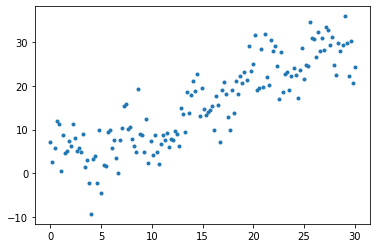

In [ ]:
plt.plot(x, Y, '.')

plt.show()

In [ ]:
class FNV(object):
    def __init__(self, kernel=None):
        self.X, self.Y = None, None
        self.kernel = lambda x: np.ones_like(x)
        if kernel is not None:
            self.kernel = kernel
    def predict(self, X):
        features = np.sum(self.Y*self.kernel(cdist(X, self.X)), axis=-1)
        return features/(np.sum(self.kernel(cdist(X, self.X)), axis=-1)+1e-10)
    def fit(self, X, Y, epoch=10):
        self.X, self.Y = np.array(X), np.array(Y)

In [ ]:
def K(distance, h=0.2):
    ret = np.array(distance)/h
    return (1 - ret**2) * (np.abs(ret) <= 1)

In [ ]:
model = FNV(kernel=lambda x: K(x, h=2))
model.fit(X, Y)

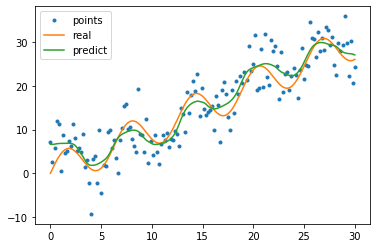

In [ ]:
plt.plot(x, Y, '.', label='points')
plt.plot(x, Y_without_noise, label='real')
plt.plot(x, model.predict(X), label='predict')

plt.legend(loc='best')
plt.show()

In [ ]:
np.random.seed(0)
l = 150

# Генерация данных
x = np.linspace(0, 30, num=l)
Y_without_noise = x + 4*np.sin(x)
Y = Y_without_noise + 4*np.random.randn(l)

# Генерация признаков
X = np.array([x]).T

In [ ]:
model = FNV(kernel=lambda x: K(x, h=2))
model.fit(X, Y)

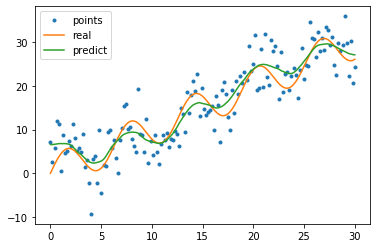

In [ ]:
plt.plot(x, Y, '.', label='points')
plt.plot(x, Y_without_noise, label='real')
plt.plot(x, model.predict(X), label='predict')

plt.legend(loc='best')
plt.show()